# Algorithmic Trading Çalışması

Bu notebook'ta çeşitli makine öğrenmesi metodları kullanılarak algorithmic trading yapılmaya çalışılmaktadır.
***
**Hazırlayan:** Yağız Yılmaz

## Import'lar ve Ayarlamalar

In [8]:
# interactive output'lar için:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Burada Boris Banushev'in çalışması kullanılmıştır.
<br>
Github: https://github.com/borisbanushev/stockpredictionai
<br>
Medium: https://towardsdatascience.com/aifortrading-2edd6fac689d

In [9]:
# Boris Bonushev'in çalışmasının inputları:
from utils import *
import time
import datetime
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx

import matplotlib.pyplot as plt
# matplotlib görsellerini notebook'ta görmek için:
%matplotlib inline
import seaborn as sns

import math

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [10]:
# daha güzel grafikler için:
sns.set()

In [11]:
# warning ayarlamaları
import warnings

# test için:
warnings.filterwarnings("always")
warnings.warn("warning test 1")

warnings.filterwarnings("ignore")
# tüm warningler ignore edilir, gösterilmez.
warnings.warn("warning test 2")

/Users/yagizyilmaz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: warning test 1
  


## Veri Girişi

Burada Boris MXNet için işlemler yapıyor. NEDEN???

In [12]:
context = mx.cpu()
model_ctx = mx.cpu()
mx.random.seed(1719)

**MXNet ile ilgili çeşitli bilgiler:** (internetten bulundu)

- Apache MXNet, derin sinir ağlarını eğitmek ve yerleştirmek için kullanılan açık kaynaklı bir derin öğrenme yazılımı çerçevesidir. Hızlı model eğitimi sağlayan ölçeklenebilir ve esnek bir programlama modelini ve çoklu programlama dilini destekler

- MXNet, Keras gibi yüksek seviye kütüphanedir, ancak farklı şekillerde bizlere kolaylıklar sağlıyor.

- Bir taraftan, MXNet’i kullanarak Keras’ı kullanmaktan çok bir ağ oluşturmak için daha fazla çaba gerektiriyor. Daha az öğretici sayesinde daha keskin bir öğrenme eğrisi bulduk.

- Bununla birlikte, bunun için 7 farklı dilde çalışmalarınızı destekler! Bunlar arasında C++, Python, R, Javascript ve hatta Matlab bulunur.

- MXNet gerçek bir polyglot (çok dilli) olmasından dolayı, farklı dillerde model paylaşan ekipler için harika çözümler sunmaktadır.

- MXNet’in diğer bir avantajı da dağıtılmış bilgi işlemini desteklemesidir. Bu, birden fazla CPU veya GPU üzerinde eğitim vererek, eğitim hızını artırma ihtiyacınız varsa, MXNet sizin için doğru kütüphanedir.

### Dosyayı Okuma

In [13]:
# zamanı tanıtmak için:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [32]:
file_name = "GS.csv"
data = pd.read_csv(file_name,
                   header=0,
                   usecols=['Date', 'Open'],
                   parse_dates=['Date'],
                   date_parser=parser)
data = data.dropna()
data = data.reset_index(drop=True)
data.head()

# header=0 birinci satır header'dır.

,Date,Open
0,2000-01-13,85.125
1,2000-01-14,85.500
2,2000-01-18,85.000
3,2000-01-19,86.875
4,2000-01-20,87.000


In [18]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 5030 number of days in the dataset.


**Plot bastır:**

<Figure size 1400x500 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'USD')

Text(0.5, 1.0, 'Goldman Sachs stock price')

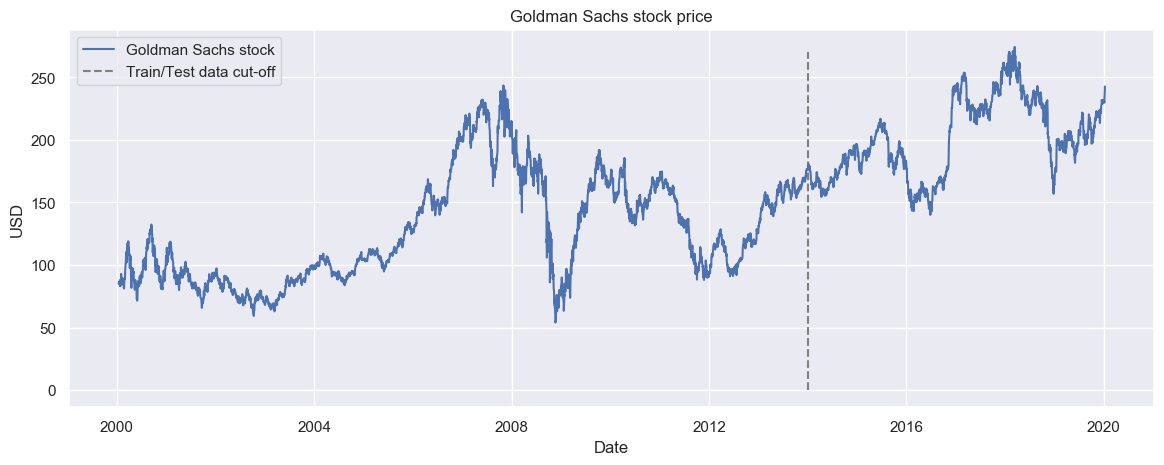

In [36]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(data['Date'], data['Open'], label='Goldman Sachs stock')

# yaklaşık olarak dikey çizgiyi çizdirdim:
plt.vlines(datetime.date(2014, 1, 1),
           0,
           270,
           linestyles='--',
           colors='gray',
           label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Goldman Sachs stock price')
plt.legend()
plt.show()

## Monte Carlo Simülasyonu Çalışması

### Pi Sayısı Hesaplama Örneği

**İlgili linkler:**
<br>
https://medium.com/@sddkal/python-ile-monte-carlo-sim%C3%BClasyonu-fcacad9f7649
<br>
https://furkanonder.github.io/Monte-Carlo-Methodu-Ile-Pi-Sayisinin-Hesaplanmasi

In [40]:
def monte_carlo_pi(number_of_samples=5000000):
    ''' Get pi form a unit square and a unit circle '''

    # icerdekilerin sayisi
    inside = 0

    for i in range(number_of_samples):
        x = np.random.rand()
        y = np.random.rand()  # iki adet random sayi uret

        if np.square(x) + np.square(
                y) < 1:  # birim cemberin icindeyse(orjine uzakligi 1'den azsa)
            inside += 1  # icerideki sayisini arttir

    return 4 * float(
        inside
    ) / number_of_samples  # 4 * icerideki / hepsi(karenin icinde kalma olasiliigi gibi dusunebiliriz)


print(monte_carlo_pi())

3.1412872


**Alıntı:**
<br>
<br>
Merhaba, Bugünki yazımda Monte Carlo Metodu ile pi sayısının hesaplanmasını anlatacağım.Öncelikle Monte Carlo Metodu’nu tanıyalım.
<br>
<br>
Monte Carlo Metodu, genel olarak istatistiksel simülasyonların yapılması için rastgele sayılardan faydalanılan bir metot olarak tanımlayabiliriz. Los Alamos Bilimsel Laboratuar’ından John Von Neumann, Stan Ulam ve Nick Metropolis adlarında üç bilim adamı tarafından ortaya çıkarılmıştır.Monte Carlo metodu ilk defa II.Dünya Savaşı sırasında atom bombasının geliştirilmesi ile ilgili problemlere uygulanmıştır.Günümüzde bu metot,Hücre Simülasyonu, Borsa Modelleri, Dağılım Fonksiyonları,Atom ve Molekül Fiziği, Nükleer Fizik modellerini test eden simülasyonlarının hesaplanmalarında kullanılır.
<br>
<br>
Şimdi Monte Carlo Metodu ile pi sayısının hesaplanmasına geçelim.Alanı 4 birim kare olan bir kare düşünelim. Karenin içine de teğet olarak yerleştirilmiş yarıçapı 1 birim olan bir çember(birim çember) çizelim.
<br>
<br>
Karenin içine kordinatları Z(a, b) noktası gibi rastgele atışlar gerçekleştirelim.Yaptığımız rastgele atışların bir kısmı çemberin içinde bir kısmı ise dışında olacaktır.Yapılan atışların:
<br>
<br>
$$\frac{\text{Çemberin içinde kalma olasılığı}}{\text{Karenin içinde kalma olasılığı}}=\frac{\pi*r^{2}}{(2r)^2}=\frac{\pi}{4}$$
<br>
<br>
olarak hesaplanır.Elde ettiğimiz bu ifadeyi 4 ile çarptığımızda ise yaklaşık olarak pi sayısını elde ederiz.